In [1]:

from shape_utils import Rectangle,Point,HoughLine
import glob
import math
import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
import cv2
import random as ran
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
import joblib
%matplotlib inline

In [2]:

model, testx ,testy =joblib.load("Vision.pkl");
scaler = joblib.load("Scaler.pkl");


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [3]:

defaultLeftLine = HoughLine(p1 = Point(300,720), p2 = Point(620,510))
defaultRightLine = HoughLine( p1 = Point(1280,720),p2 = Point(826,510))

def region_of_interest(img, vertices,match_mask_color = 255):
    mask = np.zeros_like(img)
    #channel_count = img.shape[2]
    #match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def region_of_interest2(img, vertices,match_mask_color = 255):
    mask = np.ones_like(img)
    #channel_count = img.shape[2]
    #match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_or(img, mask)
    return masked_image


def getCompleterPoints(img,line):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    height = img.shape[0]
    y_upper = int(height/(3/2))+30
    y_lower = height
    
    upperPoint = Point(0,y_upper)
    lowerPoint = Point(0,y_lower)
    
    upperPoint.x = int(((y_upper - line.p1.y)+(line.getSlope()*line.p1.x))/line.getSlope())
    lowerPoint.x = int(((y_lower - line.p1.y)+(line.getSlope()*line.p1.x))/line.getSlope())
    result = [upperPoint,lowerPoint]
    
    return result

def drow_the_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=10)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

def drow_the_lines2(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    

    for line in lines:
        upperPoint = line[0] 
        lowerPoint = line[1] 
        cv2.line(blank_image, (upperPoint.x,upperPoint.y), (lowerPoint.x,lowerPoint.y), (0, 255, 0), thickness=10)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img



def drow_the_lines3(img, houghLines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    

    for houghLine in houghLines:
        #for l in houghLine.line:
        x1,y1,x2,y2 = houghLine.line.ravel()
        cv2.line(blank_image, (x1,y1), (x2,y2), (0, 255, 0), thickness=10)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img


def deleteRepeatedLines(houghLines):
    minPos = 10000
    maxNeg  = -10000
    result = []
    global defaultLeftLine
    global defaultRightLine
    #defaultLeftLine = HoughLine(p1 = Point(300,720), p2 = Point(620,510))
    #defaultRightLine = HoughLine( p1 = Point(1280,720),p2 = Point(826,510))
        
    for line in houghLines:
        if line.getSlope() >0 and line.getSlope() < minPos :
            #minPos = lines.getSlope()
            #resultP.append(line)
            minPos = line.getSlope()

        if line.getSlope() <0 and line.getSlope() > maxNeg :
            #minPos = lines.getSlope()
            #resultP.append(line)
            maxNeg = line.getSlope()
            
    for line in houghLines :
        if line.getSlope() == minPos or line.getSlope() == maxNeg : 
            result.append(line)
    
    tmp = result.copy()
    if len(tmp) >=2 :
        for line in result :
            if line.getSlope() <0:
                tmp[0] = line
            else:
                tmp[1] = line
            
        result = tmp
    elif len(tmp) ==1 :
        if result[0].getSlope() < 0 :
            tmp[0] = result[0]
            #tmp.append(HoughLine( p1 = Point(1280,720),p2 = Point(826,510)))
            tmp.append(defaultRightLine)
        else :
            tmp[0] = result[0]
            #tmp.append(HoughLine(p1 = Point(300,720), p2 = Point(620,510)))
            tmp.append(defaultLeftLine)
        
        result = tmp
    elif len(tmp) ==0:
        #tmp.append(HoughLine(p1 = Point(300,720), p2 = Point(620,510)))
        #tmp.append(HoughLine( p1 = Point(1280,720),p2 = Point(826,510)))
        tmp.append(defaultLeftLine)
        tmp.append(defaultRightLine)
        
        
        result = tmp
    
    #defaultLeftLine = result[0]
    #defaultRightLine = result[1]
        
    return result


def distanceFromBaseLine(img,box):
    p0 = (box.l3[0],img.shape[0])
    p1 = (box.l3[0],box.l3[1])
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)



def predOut(img2):
    from skimage.feature import hog
    
    img = img2.copy() # assumed 64x64
    img=cv2.resize(img, (64,64))
    img_hog = hog(img, orientations=9, pixels_per_cell=(16, 16),cells_per_block=(2, 2), visualize=False, multichannel=False)

    sc = scaler.transform(img_hog.reshape(1,-1))
    pred = model.predict(sc)
    
    return int(pred)


def reco(img,div_size=None,win_sz=None,rand_selection=True,slide_ratio=1/4):
    ios = []
    img2 = img.copy()
    if (div_size!=None):
        new_x_dim = int(img2.shape[1]/div_size)
        new_y_dim = int(img2.shape[0]/div_size)
        img2 = cv2.resize(img2,(new_x_dim,new_y_dim))
        img2 = cv2.GaussianBlur(img2,(1,1),cv2.BORDER_DEFAULT) # don't know how much is needed
    
    copy1 = img2.copy()
    copy2 = img2.copy()
    
    if(win_sz==None):
        window_size = 64 # 64 X 64 this is the default window size
    else:
        window_size = win_sz
    
    window = np.ones((window_size,window_size))
    #   Sliding widow loop (not very efficent but works)
    i=0
    while (i + window_size) < (copy1.shape[0]) : # y , vertical
        j=0
        while (j + window_size) < (copy1.shape[1]): # x , horizontal
            
            window = copy1[i:window_size+i,j:window_size+j] # copy[vertical, horizontal]

            if predOut(window): # window
                if(np.random.randint(0,3)==0 and rand_selection): # 33.33% chance of drawing box = less boxes
                    copy2 = cv2.rectangle(copy2, (j,i), (j+window_size,i+window_size ), (255,0,0), 2)
                    ios.append((j,i))
                elif(not rand_selection):
                    copy2 = cv2.rectangle(copy2, (j,i), (j+window_size,i+window_size ), (255,0,0), 2)
                    #ios.append((j,i))
                    x1 = np.int( j +  window_size)
                    y1= np.int( i + window_size)
                    ios.append(((j,i),(x1,y1)))

            j+= int(window_size*slide_ratio)
        i+= int(window_size*slide_ratio)

    return copy2,ios #indecies of squares



def Myheat(heatmap, bbox_list):
    
    for box in bbox_list:
        
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    
    return heatmap

def apply_threshold(heatmap, threshold):
    
    heatmap[heatmap <= threshold] = 0
    
    return heatmap



def Mydraw(img, labels):
    img2 =np.copy(img)
    boxes = []
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        boxes.append(bbox)
        cv2.rectangle(img2, bbox[0], bbox[1], (0,0,255), 6)
    
    
    return (img2,boxes)



def recognize_full(img) :
    out,win1 = reco(img,div_size=1,win_sz=64,rand_selection=False,slide_ratio=0.25)
    out,win2 = reco(img,div_size=1,win_sz=80,rand_selection=False,slide_ratio=0.25)
    out,win3 = reco(img,div_size=1,win_sz=128,rand_selection=False,slide_ratio=0.25)
    out,win4 = reco(img,div_size=1,win_sz=96,rand_selection=False,slide_ratio=0.25)
    wins = win1 + win2+win3+win4
    
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = Myheat(heat,wins)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,8)
    heatmap = np.clip(heat, 0, 255)
    heat_image=heatmap
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result,boxes = Mydraw(img,labels)
    

    return (result,boxes)







In [36]:
## TODO :// Remove the uneccsary #print statements
def detectLane(image, err = None,output_steps = False):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    y_upper = int(height/(3/2))+30
    region_of_interest_vertices = [
        (0, height),
        ((width/3)+100, int(height/(3/2)) +30 ),
        (width/3+400, int(height/(3/2))+30 ),
        (width, height)
    ]
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    canny_image = cv2.Canny(gray_image, 50, 150)
    cropped_image = region_of_interest(canny_image,
                    np.array([region_of_interest_vertices], np.int32),)
    
    if output_steps == True  :
        cv2.imwrite("detectedLanes/canny_image.jpg",canny_image)
        cv2.imwrite("detectedLanes/cropped_image.jpg",cropped_image)
        
        
    
    
    
    lines = cv2.HoughLinesP(cropped_image,
                        rho=6,
                        theta=np.pi/180,
                        threshold=90,
                        lines=np.array([]),
                        minLineLength=1,
                        maxLineGap=150)



    image_with_lines = drow_the_lines(image, lines)
    if output_steps == True :
        cv2.imwrite("detectedLanes/incomplete1.jpg",image_with_lines)
    
    
    houghLines = []
    for line in lines:
        line = line.ravel()
        houghLines.append(HoughLine(line))
    
    


    finalLines = []
    for line in houghLines :
        if  line.getSlope() >0.4 or  line.getSlope() < -0.5:
            finalLines.append(line)


    image_with_lines = drow_the_lines3(image, finalLines)
    if output_steps == True :
        cv2.imwrite("detectedLanes/incomplete2.jpg",image_with_lines)
    
    # Deleting repeted lines with trheshhold
    finalLines = deleteRepeatedLines(finalLines)
    image_with_lines = drow_the_lines3(image, finalLines)
    if output_steps == True :
        cv2.imwrite("detectedLanes/incomplete3.jpg",image_with_lines)


    
    
    try :
        finalLines[0] =getCompleterPoints(image,finalLines[0])
    except IndexError :
        
        finalLines[0].append([Point(200,720),Point(526,510)])
        #print("finalLines[0] IndexError " )
        
        
    try :
        finalLines[1] =getCompleterPoints(image,finalLines[1])
    except IndexError :
        finalLines.append([(Point(1280,720),Point(826,510))])
        #print("finalLines[1]] IndexError " )
    
       
    
    leftRightLines = [HoughLine(p1 = finalLines[0][0],p2=finalLines[0][1]),HoughLine(p1 = finalLines[1][0],p2=finalLines[1][1])]
    
    
    
    for line in leftRightLines :
        if line.getSlope() < 0 :
            
            leftLine = line
        else : 
            rightLine = line
            
    leftLine = HoughLine(p1 = finalLines[0][0],p2=finalLines[0][1])
    rightLine = HoughLine(p1 = finalLines[1][0],p2=finalLines[1][1]) 
    
    road_verices = [
    leftLine.p1.getPoints(),
    leftLine.p2.getPoints(),
    rightLine.p2.getPoints(),
    rightLine.p1.getPoints()
]
    
    if len(finalLines) >2 :
        return err
    if(len(finalLines) ==0):
        finalLines.append([Point(200,720),Point(526,510)])
    if(len(finalLines) ==1):
        finalLines.append([Point(200,720),Point(526,510)])

    image_with_lines = drow_the_lines2(image, finalLines)
    cv2.fillPoly(image_with_lines, np.array([road_verices], np.int32), (0,0,0))
    
    return image_with_lines
    
    

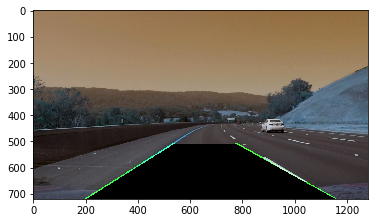

In [37]:
img_name = "test/test3.jpg"
img = cv2.imread(img_name)
image_with_lanes = detectLane(img,output_steps=True)
plt.imshow(image_with_lanes);



In [6]:

imgs = [cv2.imread(file) for file in glob.glob("test/*.jpg")]

for i in range(0,len(imgs)):
    imgs[i] = detectLane(imgs[i]);
    cv2.imwrite("detectedLanes/lane"+str(i)+".jpg",imgs[i])

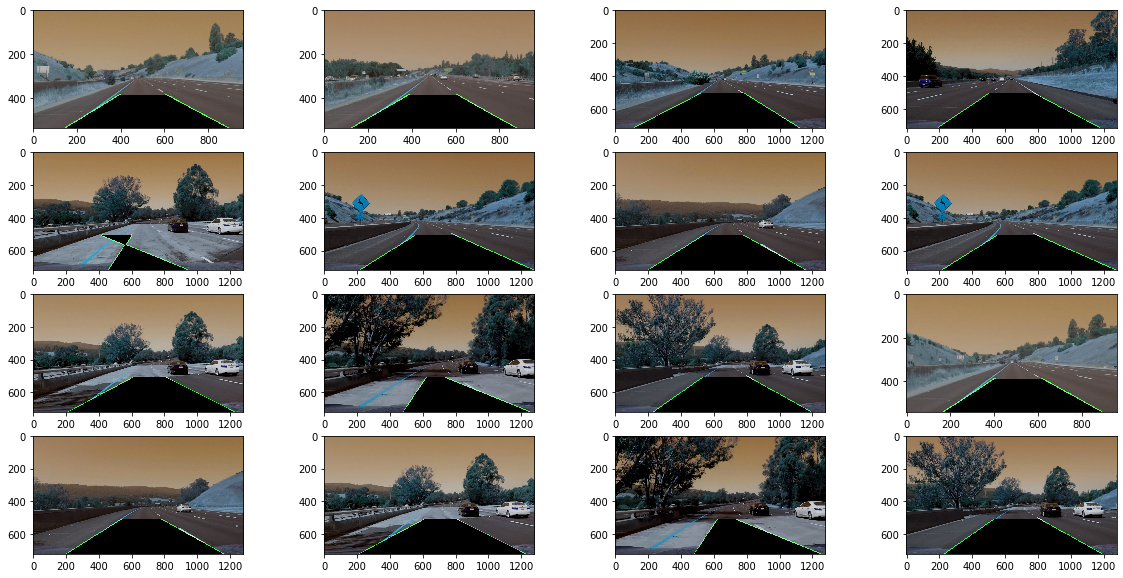

In [7]:


fig , axes = plt.subplots(4,4)
fig.set_size_inches(20,10)
axes = axes.flatten()
for i in range(0,16) : 
    plt.sca(axes[i])
    plt.imshow(imgs[i])
    
    

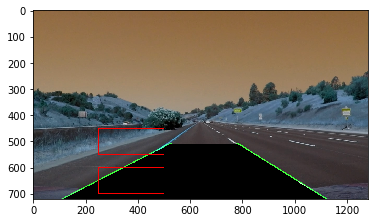

In [23]:
box1 = Rectangle(250,600,100,250)
box11 = Rectangle(250,450,100,250)
box2 = Rectangle(1100,600,100,100)
box3 = Rectangle(500,450,100,100)
box4 = Rectangle(550,800,100,250)
box5 = Rectangle(1100,200,100,300)
box6 = Rectangle(500,650,100,100)

def drawRectangle(img,box): # r stands for rectangle
    #print(box.p[3].y+box.h," Vs ", img.shape[0])
    if box.p[0].y + box.h >= img.shape[0] :
        box = Rectangle(0,0,100,250)
        
    cv2.rectangle(img, (box.p[0].x, box.p[0].y), (box.p[3].x, box.p[3].y), (255,0,0), 2)
    return box
    
        
    
def generateTest(i,box1,box11 , output_steps = False):  
    testImg = imgs[i].copy()
    drawRectangle(testImg,box1)
    drawRectangle(testImg,box11)
    if output_steps ==True : 
        cv2.imwrite("detectedLanes/generatedTestImg.jpg",testImg)
    return testImg


test = generateTest(2,box1,box11,output_steps=True)
cv2.circle(img,(box1.l2[0],box1.l2[1]),10,(0,0,255),10)
cv2.circle(img,(box1.l2[2],box1.l2[3]),10,(0,0,255),10)


plt.imshow(test)

In [32]:
def getBoxScore(img,box,withDistance=False,boxPercentage = False, output_steps = False):
    num_of_black = 0
    score = 0
    areaPercentage = 0
    dist = 0
    slicedImage = img[box.y:box.y+box.h,box.x:box.x+box.w]
    slicedImageArea = slicedImage.shape[0] * slicedImage.shape[1]
    ##print("Sliced image shape is ",slicedImage.shape)
    ##print("Box area is ",slicedImageArea)
    boxFilter = np.ones((box.w,box.h))
    
    if boxPercentage == False :
        unique , counts = np.unique(img,return_counts=True)
        num_of_black = counts[0]
        score = np.convolve(slicedImage.flatten(),boxFilter.flatten())
        unique , counts = np.unique(slicedImage,return_counts=True)
        areaPercentage = 100*(counts[0]/num_of_black)
    else :
        unique , counts = np.unique(slicedImage[:,:,0],return_counts=True)
        try :
            num_of_black = counts[0]
        except IndexError:
            box = Rectangle(0,0,0,0)
            areaPercentage = 0
            dist = 99999
            if withDistance == True : 
                return (areaPercentage,dist)
            return areaPercentage
        
        ##print(unique)
        
        areaPercentage = num_of_black/slicedImageArea
        ##print("Number of black is ",num_of_black,"\nBox area is ",slicedImageArea)
        
    if output_steps == True  :
        cv2.imwrite("detectedLanes/slicedImage.jpg",slicedImage)
    
    plt.imshow(slicedImage)


    if withDistance == True : 
        dist = distanceFromBaseLine(img,box)
        #print("Distance :", dist)
        #print("Area ", areaPercentage)
        #return (areaPercentage / 0.01*dist)
        return (areaPercentage,dist)
    else :
        return areaPercentage

(0.89792, 20.0)

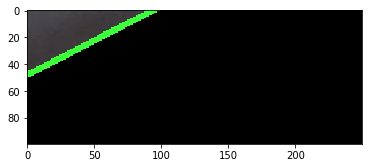

In [33]:
getBoxScore(imgs[2],box1,withDistance=True,boxPercentage=True,output_steps=True)

(0.03, 170.0)

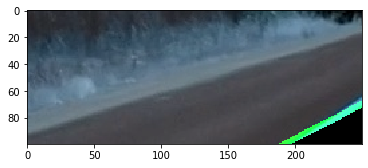

In [35]:
getBoxScore(imgs[2],box11,withDistance=True,boxPercentage=True,output_steps=True)

In [12]:


import time
 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('project_video.mp4')
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('final_output2.avi',fourcc, 20.0, (int(cap.get(3)),int(cap.get(4))))

# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

# Read until video is completed
areaWarning = False
areaDanger = False
distanceWarning = False
distanceDanger = False

i = 1
box11 = Rectangle(570,450,100,250)
box22 = Rectangle(1000,450,100,250)
box33 = Rectangle(300,450,100,250)
box44 = Rectangle(37,450,300,40)
box55 = Rectangle(570,450,100,250)
detecionCalled = False
while(cap.isOpened()):
  #time.sleep(0.1)
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
 # Display the resulting frame
        tmpFrame = frame.copy()
        #print("SHAPE ",frame.shape)
                
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,500)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2

        cv2.putText(frame,'Frame#'+str(i), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
        frame = detectLane(frame,err = tmpFrame)
        if i % 3 == 0 :
            print("Frame ",i)
        
        if i > 150  :

            grayFrame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            result,boxes  = recognize_full(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
            imageBoxes = []
            for indexes in boxes :
                box = Rectangle(indexes[0][0],indexes[0][1],0,0,x2 = indexes[1][0] , y2= indexes[1][1], asPoints= True)
                imageBoxes.append(box)
                drawRectangle(frame,box)

            
        tmpFrame = frame.copy()
        #print("SHAPE ",frame.shape)
        
        frame = detectLane(frame,err = tmpFrame)
        
        
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,500)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2

        cv2.putText(frame,'Frame#'+str(i), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)
        
        if box11.x >= 30 and i >= 900 :
            if i % 5 == 0 :
                box11.pushDown(20)
            box11 = drawRectangle(frame,box11)
            score = getBoxScore(frame,box11,withDistance=True,boxPercentage=True)
            if score[0] > 0.5 : 
                areaWarning = True
            else :
                areaWarning = False
            if score[1] < 120 and score[0]>0.25 :
                #print("XYXYXT", score[0])
                distanceWarning = True
            else : 
                dstanceWarning = False
            
            if distanceWarning == True and score[1] < 50 and score[0]>0.2 :
                distanceDanger = True
            else :
                distanceDanger = False
            
            cv2.putText(frame,'Box Area Percentage'+"{:.2f}%".format(100 *score[0])+"   Box Distance "+"{:.2f}".format(score[1]), 
            (100,100), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
            if areaWarning == True :
                cv2.putText(frame,'Warning Box Area High',
            (100,150), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
            
            if distanceWarning == True :
                cv2.putText(frame,'Warning Box is close',
            (100,200), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
        
            if distanceDanger == True : 
                 cv2.putText(frame,'Danger',
            (300,300), 
            font, 
            3,
            (0,0,255),
            lineType)
        
        else :
            areaWarning = False 
            areaDanger = False
            distanceDanger = False
            distanceWarning = False
            
            
        if i >= 945 :
            if box22.x >= 30 :
                if i % 5 == 0 :
                    box22.pushDown(20)
                box22 = drawRectangle(frame,box22)
                score = getBoxScore(frame,box22,withDistance=True,boxPercentage=True)
                if score[0] > 0.5 : 
                    areaWarning = True
                else :
                    areaWarning = False
                if score[1] < 120 and score[0]>0.25 :
                    #print("XYXYXT", score[0])
                    distanceWarning = True
                else : 
                    dstanceWarning = False
            
                if distanceWarning == True and score[1] < 50 and score[0]>0.2 :
                    distanceDanger = True
                else :
                    distanceDanger = False
            
                cv2.putText(frame,'Box Area Percentage'+"{:.2f}%".format(100 *score[0])+"   Box Distance "+"{:.2f}".format(score[1]), 
            (100,100), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
                if areaWarning == True :
                    cv2.putText(frame,'Warning Box Area High',
            (100,150), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
            
                if distanceWarning == True :
                    cv2.putText(frame,'Warning Box is close',
            (100,200), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
        
                if distanceDanger == True : 
                     cv2.putText(frame,'Danger',
            (300,300), 
            font, 
            3,
            (0,0,255),
            lineType)
        
        else :
            areaWarning = False 
            areaDanger = False
            distanceDanger = False
            distanceWarning = False
            
            
        if i >= 985 :
            if box33.x >= 30 :
                if i % 5 == 0 :
                    box33.pushDown(20)
                box33 = drawRectangle(frame,box33)
                score = getBoxScore(frame,box33,withDistance=True,boxPercentage=True)
                if score[0] > 0.5 : 
                    areaWarning = True
                else :
                    areaWarning = False
                if score[1] < 120 and score[0]>0.25 :
                    
                    distanceWarning = True
                else : 
                    dstanceWarning = False
            
                if distanceWarning == True and score[1] < 50 and score[0]>0.2 :
                    distanceDanger = True
                else :
                    distanceDanger = False
            
                cv2.putText(frame,'Box Area Percentage'+"{:.2f}%".format(100 *score[0])+"   Box Distance "+"{:.2f}".format(score[1]), 
            (100,100), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
                if areaWarning == True :
                    cv2.putText(frame,'Warning Box Area High',
            (100,150), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
            
                if distanceWarning == True :
                    cv2.putText(frame,'Warning Box is close',
            (100,200), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
        
                if distanceDanger == True : 
                     cv2.putText(frame,'Danger',
            (300,300), 
            font, 
            3,
            (0,0,255),
            lineType)
        
        else :
            areaWarning = False 
            areaDanger = False
            distanceDanger = False
            distanceWarning = False
            
            
        if i >= 1030 :
            if box44.x >= 30 :
                if i % 5 == 0 :
                    box44.pushDown(20)
                box44 = drawRectangle(frame,box44)
                score = getBoxScore(frame,box44,withDistance=True,boxPercentage=True)
                if score[0] > 0.5 : 
                    areaWarning = True
                else :
                    areaWarning = False
                if score[1] < 120 and score[0]>0.25 :
                    
                    distanceWarning = True
                else : 
                    dstanceWarning = False
            
                if distanceWarning == True and score[1] < 50 and score[0]>0.1 :
                    distanceDanger = True
                else :
                    distanceDanger = False
            
                cv2.putText(frame,'Box Area Percentage'+"{:.2f}%".format(100 *score[0])+"   Box Distance "+"{:.2f}".format(score[1]), 
            (100,100), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
                if areaWarning == True :
                    cv2.putText(frame,'Warning Box Area High',
            (100,150), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
            
                if distanceWarning == True :
                    cv2.putText(frame,'Warning Box is close',
            (100,200), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
        
                if distanceDanger == True : 
                     cv2.putText(frame,'Danger',
            (300,300), 
            font, 
            3,
            (0,0,255),
            lineType)
        
        else :
            areaWarning = False 
            areaDanger = False
            distanceDanger = False
            distanceWarning = False
            

        if i >= 1100 and i <=1145 :
            if box55.x >= 30 :
                if i % 3 == 0 :
                    if i >=1125:
                        box55.pushDown(-20)
                    else : 
                        box55.pushDown(20)
                box55 = drawRectangle(frame,box55)
                score = getBoxScore(frame,box55,withDistance=True,boxPercentage=True)
                if score[0] > 0.5 : 
                    areaWarning = True
                else :
                    areaWarning = False
                if score[1] < 120 and score[0]>0.25 :
                    #print("XYXYXT", score[0])
                    distanceWarning = True
                else : 
                    dstanceWarning = False
            
                if distanceWarning == True and score[1] < 50 and score[0]>0.2 :
                    distanceDanger = True
                else :
                    distanceDanger = False
            
                cv2.putText(frame,'Box Area Percentage'+"{:.2f}%".format(100 *score[0])+"   Box Distance "+"{:.2f}".format(score[1]), 
            (100,100), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
                if areaWarning == True :
                    cv2.putText(frame,'Warning Box Area High',
            (100,150), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
            
                if distanceWarning == True :
                    cv2.putText(frame,'Warning Box is close',
            (100,200), 
            font, 
            fontScale,
            (0,255,255),
            lineType)
        
                if distanceDanger == True : 
                     cv2.putText(frame,'Danger',
            (300,300), 
            font, 
            3,
            (0,0,255),
            lineType)
        
        else :
            areaWarning = False 
            areaDanger = False
            distanceDanger = False
            distanceWarning = False


            
            
            
            
            

        #cv2.imshow("Frame",frame)
        out.write(frame)
        i +=1
 # Press Q on keyboard to  exit
        #if cv2.waitKey(25) & 0xFF == ord('q'):
            #break
 # Break the loop
    else: 
        break
 # When everything done, release the video capture object
cap.release()
out.release()
# Closes all the frames
cv2.destroyAllWindows()


Frame  3
Frame  6
Frame  9
Frame  12
Frame  15
Frame  18
Frame  21
Frame  24
Frame  27
Frame  30
Frame  33
Frame  36
Frame  39
Frame  42
Frame  45
Frame  48
Frame  51
Frame  54
Frame  57
Frame  60
Frame  63
Frame  66
Frame  69
Frame  72
Frame  75
Frame  78
Frame  81
Frame  84
Frame  87
Frame  90
Frame  93
Frame  96
Frame  99
Frame  102
Frame  105
Frame  108
Frame  111
Frame  114
Frame  117
Frame  120
Frame  123
Frame  126
Frame  129
Frame  132
Frame  135
Frame  138
Frame  141
Frame  144
Frame  147
Frame  150


KeyboardInterrupt: 